# BEM114 Homework 2 - Statistical Arbitrage
**Names:** Andrew Zabelo, Daniel Wen, Kyle McCandless  
**Student IDs:** 2176083, 2159859, 2157818

## Setup
Imports, Helper Functions, and DataFrames

In [1]:
'''
Imports
'''

import pandas as pd
import numpy as np
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [2]:
'''
Helper functions
'''

# Given a group of stocks, calculate equal-weighted and value-weighted weights
def calc_weights(group):
    # Calc equal weights
    group['weights_eq'] = 1 / float(group['decile'].count())
    # Calc total market equity of group
    group['TMV'] = group['MV'].sum()
    # Calc value weights
    group['weights_val'] = group['MV'] / group['TMV']
    return group

# Part b of problems 2,3,4: Calculates monthly returns from monthly weights
def part_b(df):
    # Calculate weights times returns
    df['weighted_val_ret'] = df['weights_val_lag'] * df['RET']
    df['weighted_eq_ret'] = df['weights_eq_lag'] * df['RET']

    # Sum up portfolio returns
    eqports = df.groupby(['date', 'decile_lag'])['weighted_eq_ret'].sum()
    eqports = eqports.unstack()
    
    # Drop if missing accounting data in early years
    eqports = eqports.dropna(axis=0)
    
    # Match data format of FF factors
    eqports = eqports * 100
    eqports = eqports.reset_index()

    valports = df.groupby(['date', 'decile_lag'])['weighted_val_ret'].sum()
    valports = valports.unstack()
    valports = valports.dropna(axis=0)
    valports = valports * 100
    valports = valports.reset_index()
    
    return eqports, valports

# Creates a graph of the decile mean returns
def graph_deciles(df, title):
    df_mean = df.mean(numeric_only=True)
    df_mean.plot(kind='bar', x='Decile Portfolio', y='values', legend=False)
    plt.xlabel('Decile Portfolio')
    plt.ylabel('Mean Monthly Returns')
    plt.title(title)
    plt.show()

# Calculates returns and prints the returns mean, vol, and Sharpe ratio for a strategy
def analyze(df, strat_name, ret_col_name, reverse=False):
    df[ret_col_name] = df[10.0] - df[1.0] if reverse else df[1.0] - df[10.0] 
    
    strat_mean = df[ret_col_name].mean()
    strat_vol = df[ret_col_name].std()
    strat_sharpe = strat_mean / strat_vol

    print(f"{strat_name} monthly returns have mean {strat_mean}, vol {strat_vol}, and Sharpe {strat_sharpe}")

# Estimates the CAPM and FF3 models on df_old using the returns found in ret_col_name
def estimate_capm_and_ff3(df_old, ret_col_name, ff3):
    # Merge in ff3 data. Keep separate from ff5 because there is a larger data range available in ff3.
    # May lose a few rows since ff3 goes back to July 1926 and our data starts Jan 1926
    df = pd.merge(df_old, ff3, how='inner', on=['date'])
    
    # Estimate CAPM
    print('CAPM')
    print(sm.OLS(df[ret_col_name] - df['RF'], sm.add_constant(df[['Mkt-RF']])).fit().summary())
    
    # Estimate FF3
    print('FF3')
    print(sm.OLS(df[ret_col_name] - df['RF'], sm.add_constant(df[['Mkt-RF', 'SMB', 'HML']])).fit().summary())

# Estimates the FF5 model on df_old using the returns found in ret_col_name, optionally adding momentum
def estimate_ff5(df_old, ret_col_name, ff5, add_momentum=False, mom_rets=None):
    # Merge in ff5 data. Truncates dates so create a df separate from ff3.
    df = pd.merge(df_old, ff5, how='inner', on=['date'])
    
    # Estimate FF5
    print('FF5')
    print(sm.OLS(df[ret_col_name] - df['RF'], sm.add_constant(df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])).fit().summary())
    
    if add_momentum:
        # Estimate FF5 + Momentum
        print('FF5 + Momentum')
        df = pd.merge(df, mom_rets, how='inner', on=['date'])
        print(sm.OLS(df[ret_col_name] - df['RF'], sm.add_constant(df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']])).fit().summary())

In [3]:
'''
Load CRSP data
'''

df = pd.read_csv('crsp_1926_2020.zip')

# Convert prices and returns to numeric and drop NaNs
df['PRC'] = pd.to_numeric(df['PRC'], errors='coerce')
df['RET'] = pd.to_numeric(df['RET'], errors='coerce')
df = df.dropna(subset=['PRC', 'RET'])

# Set types for relevant columns
df = df.astype({'date': 'string', 'SHRCD': 'int', 'EXCHCD': 'int'})

# Drop day information in the dates
df['date'] = df['date'].str[:-3]

In [4]:
'''
Load FF3 and FF5 data
'''

ff3 = pd.read_csv('ff3_factors.csv')
ff3 = ff3.astype({'date': 'string'})
ff3['date'] = ff3['date'].apply(lambda x: x[:4] + '-' + x[4:])

ff5 = pd.read_csv('ff5_factors.csv')
ff5 = ff5.astype({'date': 'string'})
ff5['date'] = ff5['date'].apply(lambda x: x[:4] + '-' + x[4:])

## Problem 1
### Part A

In [5]:
# Filter SHRCD and EXCHCD, set negative prices to NA
df = df[df['SHRCD'].isin([10, 11])]
df = df[df['EXCHCD'].isin([1, 2, 3])]
df.loc[df['PRC'] < 0, 'PRC'] = 'NA'
df

,PERMNO,date,SHRCD,EXCHCD,PRC,RET,SHROUT
2,10000,1986-02,10,3,NA,-0.257143,3680.0
3,10000,1986-03,10,3,NA,0.365385,3680.0
4,10000,1986-04,10,3,NA,-0.098592,3793.0
5,10000,1986-05,10,3,NA,-0.222656,3793.0
6,10000,1986-06,10,3,NA,-0.005025,3793.0
...,...,...,...,...,...,...,...
4705164,93436,2020-08,11,3,498.32001,0.741452,931809.0
4705165,93436,2020-09,11,3,429.01001,-0.139087,948000.0
4705166,93436,2020-10,11,3,388.04001,-0.095499,947901.0
4705167,93436,2020-11,11,3,567.59998,0.462736,947901.0


### Part B

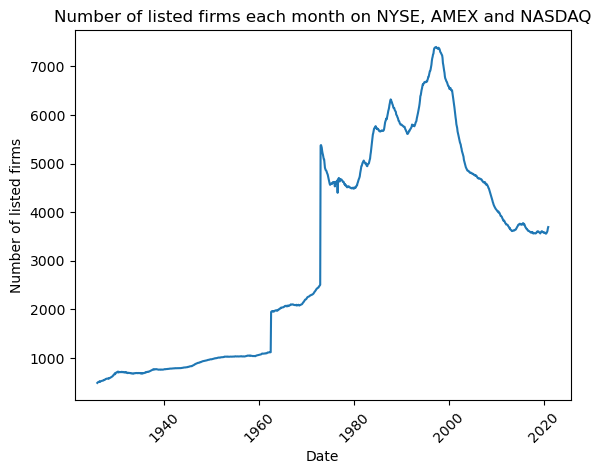

In [6]:
# Group by year and month
by_month = df.groupby(df['date'])['PERMNO'].nunique().reset_index()
by_month['date'] = pd.to_datetime(by_month['date'])

# Create plot of number of firms listed each month
plt.plot(by_month['date'], by_month['PERMNO'])
plt.title('Number of listed firms each month on NYSE, AMEX and NASDAQ')
plt.xlabel('Date')
plt.ylabel('Number of listed firms')
plt.xticks(rotation=45)
plt.show()

## Problem 2

### Part A

In [7]:
# Drop NA pricees and create MV column
df['PRC'] = pd.to_numeric(df['PRC'], errors='coerce')
df = df.dropna(subset=['PRC'])
df['MV'] = df['PRC'] * df['SHROUT']

sortdf = df.copy()
sortdf['rank'] = sortdf.groupby('date')['MV'].rank(pct=True)

# Label decile portfolios
sortdf['decile'] = np.ceil(sortdf['rank']*10)

# Calculate weights
# Introduces Nans because some rows do not have BM_decile
sortdf = sortdf.groupby(['date', 'decile'], group_keys=False).apply(calc_weights)

# Move weights and deciles forward one month
# We form portfolios at the end of this month, and then earn returns over
# the next month.
sortdf['decile_lag'] = sortdf.groupby('PERMNO')['decile'].shift(1)
sortdf['weights_val_lag'] = sortdf.groupby('PERMNO')['weights_val'].shift(1)
sortdf['weights_eq_lag'] = sortdf.groupby('PERMNO')['weights_eq'].shift(1)

sortdf = sortdf.drop(['rank', 'decile', 'weights_eq', 'TMV', 'weights_val'], axis=1)
sortdf

/var/folders/24/b7637qzn5pz9_l33fc30f4240000gn/T/ipykernel_8337/2236265313.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MV'] = df['PRC'] * df['SHROUT']


,PERMNO,date,SHRCD,EXCHCD,PRC,RET,SHROUT,MV,decile_lag,weights_val_lag,weights_eq_lag
28,10001,1986-09,11,3,6.37500,-0.003077,991.0,6.317625e+03,NaN,NaN,NaN
29,10001,1986-10,11,3,6.62500,0.039216,991.0,6.565375e+03,1.0,0.001939,0.002494
30,10001,1986-11,11,3,7.00000,0.056604,991.0,6.937000e+03,1.0,0.001996,0.002469
31,10001,1986-12,11,3,7.00000,0.015000,991.0,6.937000e+03,1.0,0.002139,0.002551
32,10001,1987-01,11,3,6.75000,-0.035714,991.0,6.689250e+03,1.0,0.002337,0.002309
...,...,...,...,...,...,...,...,...,...,...,...
4705164,93436,2020-08,11,3,498.32001,0.741452,931809.0,4.643391e+08,10.0,0.009859,0.002825
4705165,93436,2020-09,11,3,429.01001,-0.139087,948000.0,4.067015e+08,10.0,0.015874,0.002809
4705166,93436,2020-10,11,3,388.04001,-0.095499,947901.0,3.678235e+08,10.0,0.014459,0.002801
4705167,93436,2020-11,11,3,567.59998,0.462736,947901.0,5.380286e+08,10.0,0.013439,0.002793


### Part B

decile_lag
1.0     3.110296
2.0     1.509020
3.0     1.337370
4.0     1.272587
5.0     1.267089
6.0     1.215686
7.0     1.162114
8.0     1.092401
9.0     1.070809
10.0    0.924893
dtype: float64

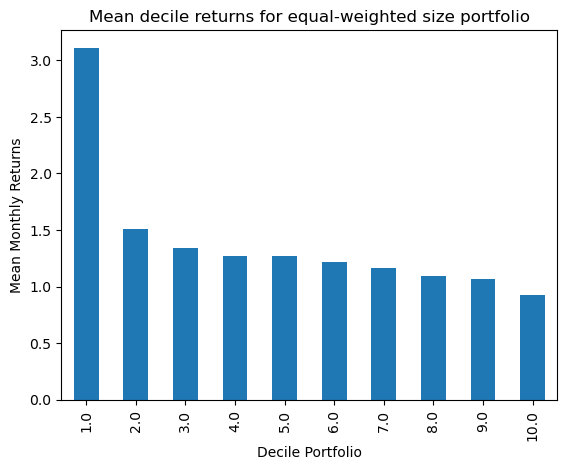

decile_lag
1.0     2.471250
2.0     1.486205
3.0     1.343516
4.0     1.268714
5.0     1.264068
6.0     1.217934
7.0     1.160938
8.0     1.084152
9.0     1.064744
10.0    0.912878
dtype: float64

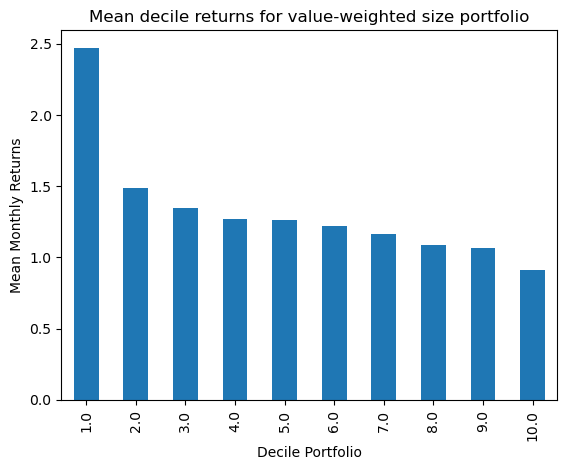

In [8]:
eqports, valports = part_b(sortdf)

display(eqports.mean(numeric_only=True))
graph_deciles(eqports, 'Mean decile returns for equal-weighted size portfolio')

display(valports.mean(numeric_only=True))
graph_deciles(valports, 'Mean decile returns for value-weighted size portfolio')

The mean monthly returns appear to be monotonic in both the equal-weighted and value-weighted portfolios. The mean returns decrease as size increases.

### Part C

In [9]:
analyze(eqports, 'Equal-weighted Size', 'RET')
analyze(valports, 'Value-weighted Size', 'RET')

Equal-weighted Size monthly returns have mean 2.1854033471142524, vol 15.054678304411805, and Sharpe 0.14516440025648475
Value-weighted Size monthly returns have mean 1.5583727812713861, vol 12.915460300728482, and Sharpe 0.12065948444620962


### Part D

In [10]:
print('Equal-Weighted Size:')
print('----------------------------------------------------------------------------------')
estimate_capm_and_ff3(eqports, 'RET', ff3)

print('\n\n\n\nValue-Weighted Size:')
print('----------------------------------------------------------------------------------')
estimate_capm_and_ff3(valports, 'RET', ff3)

Equal-Weighted Size:
----------------------------------------------------------------------------------
CAPM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     231.7
Date:                Sat, 20 Apr 2024   Prob (F-statistic):           9.47e-48
Time:                        23:32:51   Log-Likelihood:                -4581.7
No. Observations:                1134   AIC:                             9167.
Df Residuals:                    1132   BIC:                             9177.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

For both the equal-weighted and value-weighted portfolios, the alphas for the CAPM model are greater than that of the FF3 model. In the equal-weighted portfolio, the alpha for the CAPM model is 1.15 while the alpha for the FF3 model is 0.61. In the value-weighted portfolio, the alpha for the CAPM model is 0.58 while the alpha for the FF3 model is 0.11.

This makes sense with our strategy formulation because the equal-weight portfolio, if we are able to execute it, would put higher weight on the stocks we believe are undervalued (low size), causing higher alpha. From these numbers, we can also see that the alphas calculated from CAPM are higher than those from FF3.

### Part E

Equal-weighted Size monthly returns have mean 2.366380613074474, vol 17.34598770401589, and Sharpe 0.13642236195789625


decile_lag
1.0     3.278559
2.0     1.684028
3.0     1.444906
4.0     1.361792
5.0     1.335321
6.0     1.266390
7.0     1.202053
8.0     1.107576
9.0     1.092938
10.0    0.912178
RET     2.366381
dtype: float64

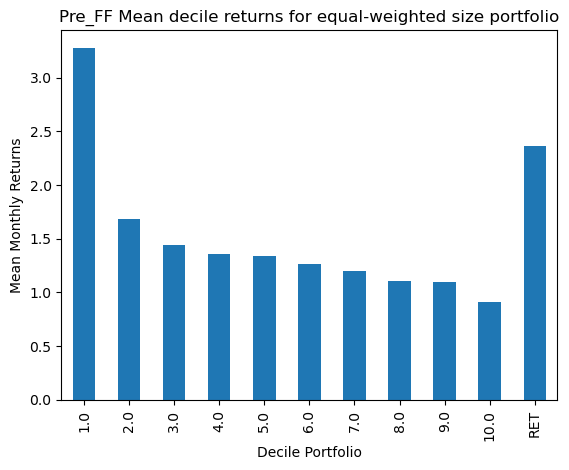

CAPM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     216.2
Date:                Sat, 20 Apr 2024   Prob (F-statistic):           2.09e-43
Time:                        23:32:51   Log-Likelihood:                -3265.2
No. Observations:                 786   AIC:                             6534.
Df Residuals:                     784   BIC:                             6544.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1710      0.554      2.113    

In [11]:
pre_FF = eqports[eqports['date'] < '1992-00'].copy()

analyze(pre_FF, 'Equal-weighted Size', 'RET')
display(pre_FF.mean(numeric_only=True))
graph_deciles(pre_FF, 'Pre_FF Mean decile returns for equal-weighted size portfolio')
estimate_capm_and_ff3(pre_FF, 'RET', ff3)

Equal-weighted Size monthly returns have mean 1.7740441017851276, vol 7.61795357856323, and Sharpe 0.23287672778385687


decile_lag
1.0     2.727837
2.0     1.111228
3.0     1.092943
4.0     1.069827
5.0     1.112000
6.0     1.100437
7.0     1.071333
8.0     1.057907
9.0     1.020510
10.0    0.953793
RET     1.774044
dtype: float64

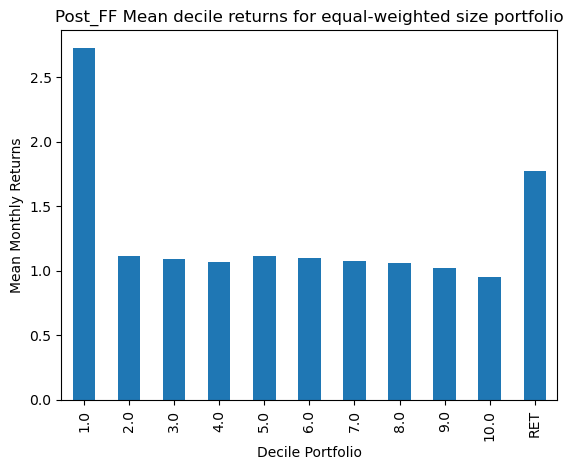

CAPM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4.021
Date:                Sat, 20 Apr 2024   Prob (F-statistic):             0.0457
Time:                        23:32:51   Log-Likelihood:                -1198.0
No. Observations:                 348   AIC:                             2400.
Df Residuals:                     346   BIC:                             2408.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4425      0.412      3.498    

In [12]:
post_FF = eqports[eqports['date'] > '1992-00'].copy()

analyze(post_FF, 'Equal-weighted Size', 'RET')
display(post_FF.mean(numeric_only=True))
graph_deciles(post_FF, 'Post_FF Mean decile returns for equal-weighted size portfolio')
estimate_capm_and_ff3(post_FF, 'RET', ff3)

Equal-weighted Size monthly returns have mean 1.3233240130717987, vol 6.181493202819268, and Sharpe 0.21407837389002618


decile_lag
1.0     2.215561
2.0     1.002400
3.0     1.084754
4.0     1.090113
5.0     1.046541
6.0     1.027662
7.0     1.007764
8.0     0.961050
9.0     1.009594
10.0    0.892237
RET     1.323324
dtype: float64

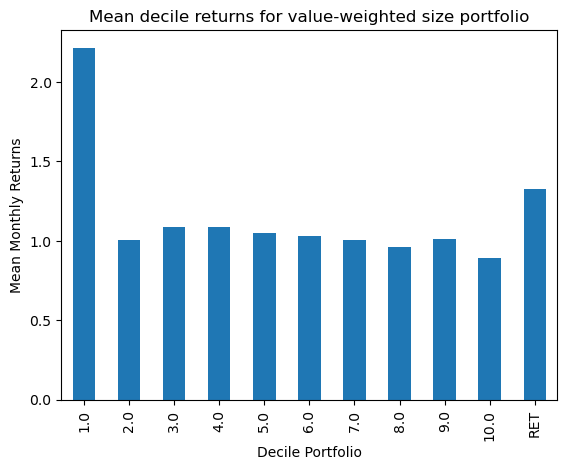

CAPM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     9.454
Date:                Sat, 20 Apr 2024   Prob (F-statistic):            0.00237
Time:                        23:32:51   Log-Likelihood:                -734.24
No. Observations:                 228   AIC:                             1472.
Df Residuals:                     226   BIC:                             1479.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0134      0.409      2.480    

In [13]:
post_DC = eqports[eqports['date'] > '2002-00'].copy()

analyze(post_DC, 'Equal-weighted Size', 'RET')
display(post_DC.mean(numeric_only=True))
graph_deciles(post_DC, 'Mean decile returns for value-weighted size portfolio')
estimate_capm_and_ff3(post_DC, 'RET', ff3)

Comparing the alpha of the size strategy before the 1992 FF paper, after the paper and before the Dot-Com Bubble, and after the Dot-Com Bubble, we conclude that the size strategy still works.

Before the Fama French 1992 paper was published, the CAPM alpha was 1.17 and the FF3 alpha was 0.34, and after the paper the CAPM alpha was 1.44 and the FF3 alpha was 1.42, showing an improvement. Additionally, the graphs of the mean monthly returns of each decile since the publication of the 1992 Fama French paper show that the 1st decile's  returns are still larger than that of the 10th decile. So, the size portfolio still works.

We can see that the same still holds for the size factor since the Dot-Com Bubble burst (post-2002), with CAPM alpha of 1.01 and FF3 alpha of 0.95. However, as we can see from the graph, although the 1st decile's mean monthly returns are still higher than the 10th decile's returns, the difference as well as the alpha values are smaller than before. So, while size still works, it does not work as well as before the Bubble.

## Problem 3
### Part A

In [14]:
# Calculate cumulative returns from month t-11 to month t-1
cum_rets = df.groupby('PERMNO')['RET'].rolling(window=11, min_periods=11).apply(lambda x: np.prod(1+x)-1).shift(1)
idx = cum_rets.index.get_level_values(1)
cum_rets = pd.Series(cum_rets.values, index=idx).rename('11M_RET')
cum_rets

28              NaN
29              NaN
30              NaN
31              NaN
32              NaN
             ...   
4705164    5.341741
4705165    9.344169
4705166    5.811416
4705167    4.880464
4705168    5.784121
Name: 11M_RET, Length: 2855895, dtype: float64

In [15]:
# Merge 11 month rolling returns into df
df_11m_rets = pd.merge(df, cum_rets, left_index=True, right_index=True)
assert(len(df_11m_rets) == len(df))
df_11m_rets = df_11m_rets.dropna(subset=['11M_RET'])
df_11m_rets

,PERMNO,date,SHRCD,EXCHCD,PRC,RET,SHROUT,MV,11M_RET
41,10001,1987-10,11,3,6.37500,0.020000,992.0,6.324000e+03,0.169797
42,10001,1987-11,11,3,6.18750,-0.029412,992.0,6.138000e+03,0.196875
43,10001,1987-12,11,3,5.87500,-0.033535,992.0,5.828000e+03,0.117836
44,10001,1988-01,11,3,6.25000,0.063830,992.0,6.200000e+03,0.022473
45,10001,1988-02,11,3,6.75000,0.080000,992.0,6.696000e+03,0.071663
...,...,...,...,...,...,...,...,...,...
4705164,93436,2020-08,11,3,498.32001,0.741452,931809.0,4.643391e+08,5.341741
4705165,93436,2020-09,11,3,429.01001,-0.139087,948000.0,4.067015e+08,9.344169
4705166,93436,2020-10,11,3,388.04001,-0.095499,947901.0,3.678235e+08,5.811416
4705167,93436,2020-11,11,3,567.59998,0.462736,947901.0,5.380286e+08,4.880464


In [16]:
# Add deciles
df_11m_rets['rank'] = df_11m_rets.groupby('date')['11M_RET'].rank(pct=True)
df_11m_rets['decile'] = np.ceil(df_11m_rets['rank']*10)

# Use calc_weights helper to get the equal- and value-weighted portfolios
df_weights = df_11m_rets.groupby(['date', 'decile'], group_keys=False).apply(calc_weights)
df_weights['decile_lag'] = df_weights.groupby('PERMNO')['decile'].shift(1)
df_weights['weights_val_lag'] = df_weights.groupby('PERMNO')['weights_val'].shift(1)
df_weights['weights_eq_lag'] = df_weights.groupby('PERMNO')['weights_eq'].shift(1)

# Process final portfolio weights
df_weights = df_weights.drop(['rank', 'decile', 'weights_eq', 'TMV', 'weights_val'], axis=1)
df_weights

,PERMNO,date,SHRCD,EXCHCD,PRC,RET,SHROUT,MV,11M_RET,decile_lag,weights_val_lag,weights_eq_lag
41,10001,1987-10,11,3,6.37500,0.020000,992.0,6.324000e+03,0.169797,NaN,NaN,NaN
42,10001,1987-11,11,3,6.18750,-0.029412,992.0,6.138000e+03,0.196875,6.0,0.000024,0.002525
43,10001,1987-12,11,3,5.87500,-0.033535,992.0,5.828000e+03,0.117836,9.0,0.000012,0.002538
44,10001,1988-01,11,3,6.25000,0.063830,992.0,6.200000e+03,0.022473,9.0,0.000013,0.002469
45,10001,1988-02,11,3,6.75000,0.080000,992.0,6.696000e+03,0.071663,8.0,0.000013,0.002653
...,...,...,...,...,...,...,...,...,...,...,...,...
4705164,93436,2020-08,11,3,498.32001,0.741452,931809.0,4.643391e+08,5.341741,10.0,0.064252,0.002967
4705165,93436,2020-09,11,3,429.01001,-0.139087,948000.0,4.067015e+08,9.344169,10.0,0.071977,0.002959
4705166,93436,2020-10,11,3,388.04001,-0.095499,947901.0,3.678235e+08,5.811416,10.0,0.058150,0.002967
4705167,93436,2020-11,11,3,567.59998,0.462736,947901.0,5.380286e+08,4.880464,10.0,0.060722,0.002959


### Part B

decile_lag
1.0     1.433417
2.0     1.275422
3.0     1.158702
4.0     1.177848
5.0     1.289182
6.0     1.366047
7.0     1.367513
8.0     1.547550
9.0     1.688353
10.0    2.012180
dtype: float64

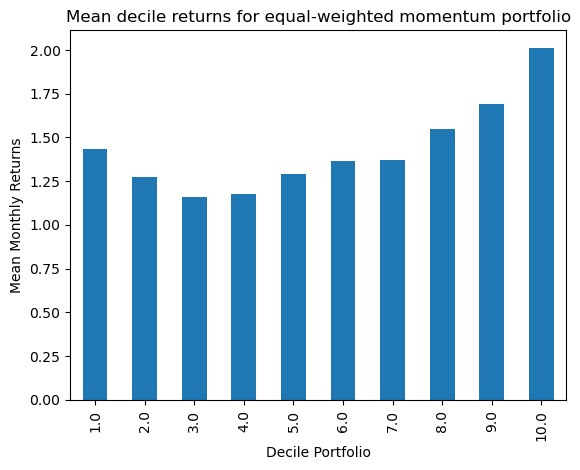

decile_lag
1.0     0.496700
2.0     0.629950
3.0     0.674610
4.0     0.795372
5.0     0.994576
6.0     0.905602
7.0     1.080470
8.0     1.149786
9.0     1.357799
10.0    1.712453
dtype: float64

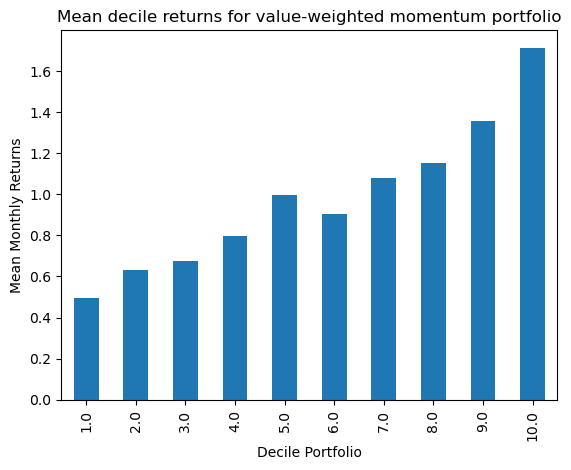

In [17]:
eq_decile_returns, val_decile_returns = part_b(df_weights)

display(eq_decile_returns.mean(numeric_only=True))
graph_deciles(eq_decile_returns, 'Mean decile returns for equal-weighted momentum portfolio')

display(val_decile_returns.mean(numeric_only=True))
graph_deciles(val_decile_returns, 'Mean decile returns for value-weighted momentum portfolio')

The equal-weighted decile returns are not monotonic, and instead follow a curved pattern where the 10th decile is higher than the 1st decile. The value-weighted decile returns are roughly monotonic, increasing as the decile increases with one exception from the 5th to 6th decile.

### Part C

In [18]:
analyze(eq_decile_returns, 'Equal-weighted Momentum', 'MOM', reverse=True)
analyze(val_decile_returns, 'Value-weighted Momentum', 'MOM', reverse=True)

Equal-weighted Momentum monthly returns have mean 0.5787633266410294, vol 10.412249945766787, and Sharpe 0.055584847622326995
Value-weighted Momentum monthly returns have mean 1.215753149735365, vol 9.423347313797782, and Sharpe 0.12901499958037674


### Part D

In [19]:
print('Equal-Weighted Momentum:')
print('----------------------------------------------------------------------------------')
estimate_capm_and_ff3(eq_decile_returns, 'MOM', ff3)
estimate_ff5(eq_decile_returns, 'MOM', ff5)

print('\n\n\n\nValue-Weighted Momentum:')
print('----------------------------------------------------------------------------------')
estimate_capm_and_ff3(val_decile_returns, 'MOM', ff3)
estimate_ff5(val_decile_returns, 'MOM', ff5)

# Save momentum returns for part 4
eq_mom_returns = eq_decile_returns[['date', 'MOM']]
val_mom_returns = val_decile_returns[['date', 'MOM']]

Equal-Weighted Momentum:
----------------------------------------------------------------------------------
CAPM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     167.4
Date:                Sat, 20 Apr 2024   Prob (F-statistic):           8.30e-36
Time:                        23:36:38   Log-Likelihood:                -4166.2
No. Observations:                1129   AIC:                             8336.
Df Residuals:                    1127   BIC:                             8346.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

Comparing the (CAPM, FF3, and FF5) alphas of the equal-weighted momentum portfolio (0.78, 1.09, 0.56) with those of the value-weighted portfolio (1.41, 1.63, 1.25), it is clear that the value-weighted momentum portfolios have far better alphas. Perhaps the momentum signal is stronger in high value firms.

Under the CAPM model, the FF3 model, and the FF5 model, the alpha that the equal-weighted and value-weighted momentum strategies are generating is statistically significant at the 5% level, with the exception of the equal-weighted FF5 alpha.

As can be seen from the results, the alpha is consistently smaller under the FF5 model, indicating that FF5 does a decent job of pricing momentum. We note a large drop in alpha, especially from the FF3 to the FF5 model, but the alpha does not completely disappear.

### Part E
We find it likely that the positive momentum alphas are indicative of some unpriced risk. For one, since the momentum papers have been out for a while and this strategy is relatively easy to implement, it stands to reason that the market has priced momentum into the equation already, and that there are many people who have run or are running this strategy.

Second, it is not hard to imagine that a momentum strategy could face extreme risk in many ways: if the portfolio is rebalanced monthly and happens to buy into hot stocks at the start of the month, there is no guarantee that this momentum will carry through the whole month, as just one example.

## Problem 4
### Part A
Notes: Losing ~3000 (<0.1% of) rows since FF website starts July 1926, Professor Sinclair's data starts January 1926. We also assume that once data starts for a given stock, then it continues to be present every month until it stops.

In [20]:
# Merge ff3 data and edit columns
df_merged = pd.merge(df, ff3, how='inner', on=['date'])
df_merged['Ret-RF'] = df_merged['RET'] - df_merged['RF']
df_merged = df_merged.drop(['SHRCD', 'EXCHCD', 'PRC', 'SHROUT', 'SMB', 'HML', 'RF'], axis=1)
df_merged

,PERMNO,date,RET,MV,Mkt-RF,Ret-RF
0,10001,1986-09,-0.003077,6317.625,-8.60,-0.453077
1,10003,1986-09,-0.057692,40149.375,-8.60,-0.507692
2,10008,1986-09,-0.155963,33867.500,-8.60,-0.605963
3,10009,1986-09,-0.092157,10315.500,-8.60,-0.542157
4,10016,1986-09,-0.020000,224959.000,-8.60,-0.470000
...,...,...,...,...,...,...
2853548,84241,1984-12,0.000000,21850.000,1.84,-0.640000
2853549,85033,1984-12,0.000000,80750.000,1.84,-0.640000
2853550,85762,1984-12,0.093750,110687.500,1.84,-0.546250
2853551,89552,1984-12,-0.027778,45543.750,1.84,-0.667778


In [21]:
# Applies the rolling ols and returns the betas where there are enough months
# or np.NaN where there are not enough months
def rolling_ols(group):
    dates = np.array(group['date'])
    
    if len(group) >= 36:
        y = group['Ret-RF']
        x = sm.add_constant(group['Mkt-RF'])
        model = RollingOLS(y, x, window=36)
        
        beta_vals = np.array(model.fit().params[['Mkt-RF']].values)
        return np.column_stack((dates, beta_vals))
    else:
        return np.column_stack((dates, np.full(len(group), np.nan)))

# Get the market beta for stock i from time t-36 to time t
beta_i_t = df_merged.groupby('PERMNO').apply(rolling_ols)
beta_i_t = pd.DataFrame(beta_i_t, columns=['beta'])
beta_i_t = beta_i_t.explode('beta')
beta_i_t[['date', 'beta']] = beta_i_t['beta'].apply(lambda el: pd.Series(el))
beta_i_t

,beta,date
PERMNO,,
10001,NaN,1986-09
10001,NaN,1986-10
10001,NaN,1986-11
10001,NaN,1986-12
10001,NaN,1987-01
...,...,...
93436,0.021938,2020-08
93436,0.022043,2020-09
93436,0.022111,2020-10


In [22]:
# Merge betas into df and drop NaN betas
df_betas = pd.merge(df_merged, beta_i_t, how='inner', on=['PERMNO', 'date'])
assert(len(df_betas) == len(df_merged))
df_betas = df_betas.dropna()
df_betas

,PERMNO,date,RET,MV,Mkt-RF,Ret-RF,beta
147437,10001,1990-06,0.014103,10052.2500,-1.09,-0.615897,0.001443
147438,10003,1990-06,-0.178571,12615.5000,-1.09,-0.808571,0.010021
147442,10020,1990-06,-0.105357,254355.7500,-1.09,-0.735357,0.003049
147444,10026,1990-06,-0.043478,68763.7500,-1.09,-0.673478,0.018605
147447,10034,1990-06,-0.011111,64013.2500,-1.09,-0.641111,0.011761
...,...,...,...,...,...,...,...
2853546,84180,1984-12,0.045455,22302.8125,1.84,-0.594545,0.021865
2853548,84241,1984-12,0.000000,21850.0000,1.84,-0.640000,0.010987
2853549,85033,1984-12,0.000000,80750.0000,1.84,-0.640000,0.034927
2853550,85762,1984-12,0.093750,110687.5000,1.84,-0.546250,0.006999


In [23]:
# Add deciles
df_betas['rank'] = df_betas.groupby('date')['beta'].rank(pct=True)
df_betas['decile'] = np.ceil(df_betas['rank']*10)

# Use calc_weights helper to get the equal- and value-weighted portfolios
df_weights = df_betas.groupby(['date', 'decile'], group_keys=False).apply(calc_weights)
df_weights['decile_lag'] = df_weights.groupby('PERMNO')['decile'].shift(1)
df_weights['weights_val_lag'] = df_weights.groupby('PERMNO')['weights_val'].shift(1)
df_weights['weights_eq_lag'] = df_weights.groupby('PERMNO')['weights_eq'].shift(1)

# Process final portfolio weights
df_weights = df_weights.drop(['rank', 'decile', 'weights_eq', 'TMV', 'weights_val'], axis=1)
df_weights

,PERMNO,date,RET,MV,Mkt-RF,Ret-RF,beta,decile_lag,weights_val_lag,weights_eq_lag
147437,10001,1990-06,0.014103,10052.2500,-1.09,-0.615897,0.001443,NaN,NaN,NaN
147438,10003,1990-06,-0.178571,12615.5000,-1.09,-0.808571,0.010021,NaN,NaN,NaN
147442,10020,1990-06,-0.105357,254355.7500,-1.09,-0.735357,0.003049,NaN,NaN,NaN
147444,10026,1990-06,-0.043478,68763.7500,-1.09,-0.673478,0.018605,NaN,NaN,NaN
147447,10034,1990-06,-0.011111,64013.2500,-1.09,-0.641111,0.011761,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2853546,84180,1984-12,0.045455,22302.8125,1.84,-0.594545,0.021865,8.0,0.000210,0.003484
2853548,84241,1984-12,0.000000,21850.0000,1.84,-0.640000,0.010987,3.0,0.000121,0.003484
2853549,85033,1984-12,0.000000,80750.0000,1.84,-0.640000,0.034927,10.0,0.001563,0.003472
2853550,85762,1984-12,0.093750,110687.5000,1.84,-0.546250,0.006999,3.0,0.001280,0.002770


### Part B

decile_lag
1.0     1.109595
2.0     1.197850
3.0     1.303389
4.0     1.452345
5.0     1.434915
6.0     1.557007
7.0     1.632715
8.0     1.563985
9.0     1.586310
10.0    1.596243
dtype: float64

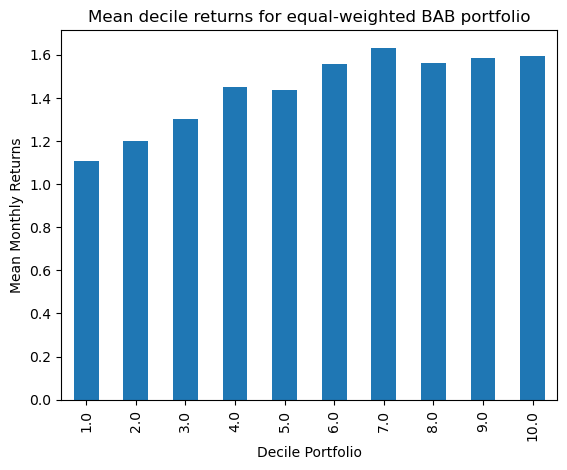

decile_lag
1.0     0.756664
2.0     0.827183
3.0     1.004737
4.0     1.135108
5.0     0.997985
6.0     1.093627
7.0     1.165584
8.0     1.161370
9.0     1.129864
10.0    1.201116
dtype: float64

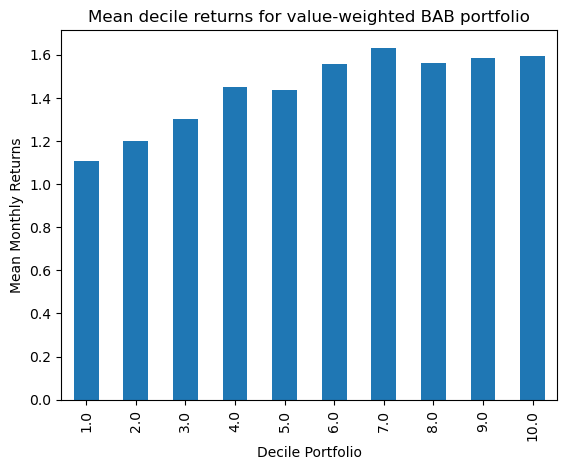

In [24]:
eq_decile_returns, val_decile_returns = part_b(df_weights)

display(eq_decile_returns.mean(numeric_only=True))
graph_deciles(eq_decile_returns, 'Mean decile returns for equal-weighted BAB portfolio')

display(val_decile_returns.mean(numeric_only=True))
graph_deciles(eq_decile_returns, 'Mean decile returns for value-weighted BAB portfolio')

Neither the mean equal-weighted BAB portfolio returns nor the mean value-weighted BAB portfolio returns are perfectly monotonic, though they follow a general upward trend with a plataeu around the 6th decile. This makes sense; as the market has gone up on average from 1926, stocks with higher beta would have higher returns on average.

### Part C

In [25]:
analyze(eq_decile_returns, 'Equal-weighted BAB', 'BAB')
analyze(val_decile_returns, 'Value-weighted BAB', 'BAB')

Equal-weighted BAB monthly returns have mean -0.4866487621371211, vol 7.928040159086454, and Sharpe -0.0613832362566132
Value-weighted BAB monthly returns have mean -0.44445208140862047, vol 8.075821235270203, and Sharpe -0.05503490833446487


### Part D

In [26]:
print('Equal-Weighted Betting-Against-Beta:')
print('----------------------------------------------------------------------------------')
estimate_capm_and_ff3(eq_decile_returns, 'BAB', ff3)
estimate_ff5(eq_decile_returns, 'BAB', ff5, add_momentum=True, mom_rets=eq_mom_returns)

print('\n\n\n\nValue-Weighted Betting-Against-Beta:')
print('----------------------------------------------------------------------------------')
estimate_capm_and_ff3(val_decile_returns, 'BAB', ff3)
estimate_ff5(val_decile_returns, 'BAB', ff5, add_momentum=True, mom_rets=val_mom_returns)

Equal-Weighted Betting-Against-Beta:
----------------------------------------------------------------------------------
CAPM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     1192.
Date:                Sat, 20 Apr 2024   Prob (F-statistic):          2.24e-177
Time:                        23:42:29   Log-Likelihood:                -3425.1
No. Observations:                1098   AIC:                             6854.
Df Residuals:                    1096   BIC:                             6864.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

The CAPM and FF3 alphas are generally small and positive, but the alphas decrease when using FF5 and decrease even more when using FF5 + Momentum. With the exception of CAPM, the equal-weighted portfolio has the higher alphas. 

### Part E
We could consider the correlation of the assets to each other, in addition to the market. We should not build a portfolio from assets that are tightly correlated but not that correlated to the market. If we diversify some of our assets but maintain the same or similar beta deciles, we can decrease our volatility and keep our returns roughly constant, resulting in a better Sharpe Ratio.